# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [1]:
# Load pickled data
import pickle

# TODO: Fill this in based on where you saved the training and testing data

training_file = 'train.p'
testing_file = 'test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train_origin, y_train_origin = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 2D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

In [2]:
### Replace each question mark with the appropriate value.

# TODO: Number of training examples
n_train = len(X_train_origin)

# TODO: Number of testing examples.
n_test = len(X_test)

# TODO: What's the shape of an traffic sign image?
image_shape = X_train_origin[0].shape

# TODO: How many unique classes/labels there are in the dataset.
n_classes = len(set(y_train_origin))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

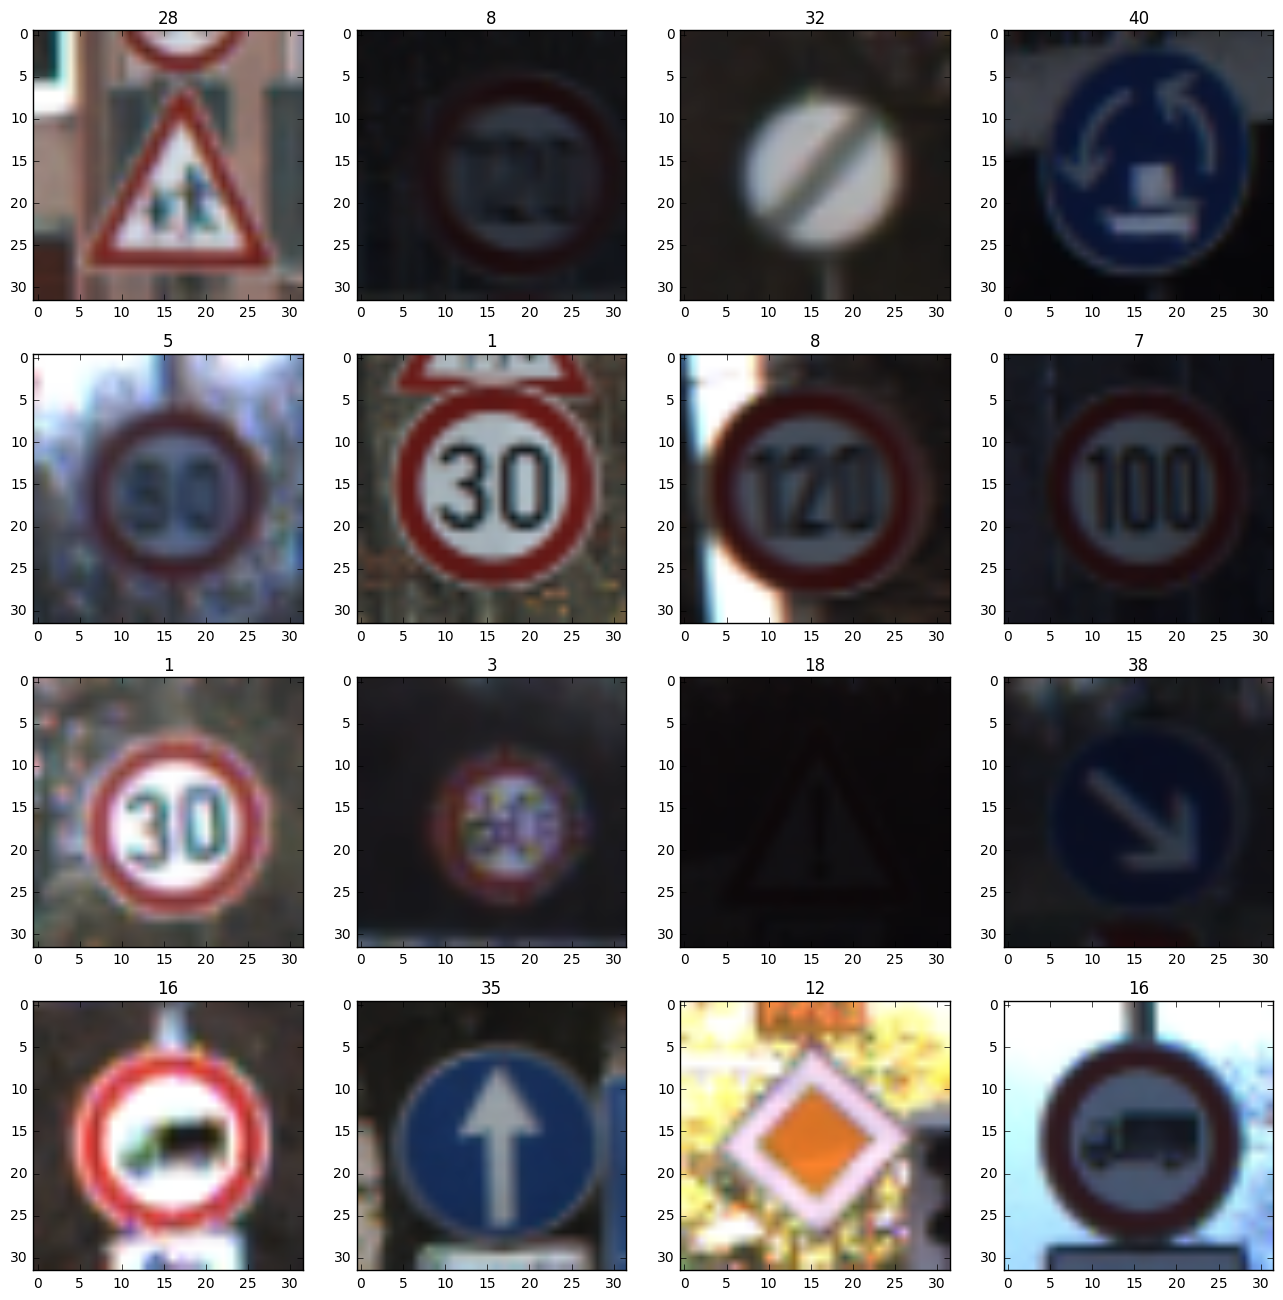

In [3]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline

import random
plt.figure(figsize=[16, 16])
for i in range(1, 17):
    plt.subplot(4, 4, i)
    num = int(random.random()*n_train)
    plt.title(y_train_origin[num])
    plt.imshow(X_train_origin[num])

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [4]:
### Preprocess the data here.
### Feel free to use as many code cells as needed.
import tensorflow as tf
from tensorflow.contrib.layers import flatten
import numpy as np
import cv2
import random

def preprocess(x):
#     gray = cv2.cvtColor(x, cv2.COLOR_BGR2GRAY)
#     normalize = (gray - gray.min()) / (gray.max() - gray.min())
    normalize = (x - x.min()) / (x.max() - x.min())
    return normalize.flatten()

def one_hot(y, classes):
    n = y.shape[0]
    offset = np.arange(n) * classes
    y_onehot = np.zeros((n, classes))
    y_onehot.flat[offset + y.ravel()] = 1
    return y_onehot

def shuffle(x, y):
    n = x.shape[0]
    p = range(n)
    random.shuffle(p)
    retX = [x[p[i]] for i in range(n)]
    retY = [y[p[i]] for i in range(n)]
    return np.array(retX), np.array(retY)

# position [-2, 2]
def transform1(x):
    M = np.float32([[1,0,-2], [0,1,2]])
    return cv2.warpAffine(x,M , (x.shape[1], x.shape[0]))

# rotate 15 degree
def transform2(x):
    (h,w) = x.shape[:2]
    center = (w/2, h/2)
    M = cv2.getRotationMatrix2D(center, 15, 1)
    return cv2.warpAffine(x, M, (w, h))

# rotate -15 degree
def transform3(x):
    (h,w) = x.shape[:2]
    center = (w/2, h/2)
    M = cv2.getRotationMatrix2D(center, -15, 1)
    return cv2.warpAffine(x, M, (w, h))

# scale 0.9
def transform4(x):
    (h,w) = x.shape[:2]
    center = (w/2, h/2)
    M = cv2.getRotationMatrix2D(center, 0, 0.9)
    return cv2.warpAffine(x, M, (w, h))

# scale 1.1
def transform5(x):
    (h,w) = x.shape[:2]
    center = (w/2, h/2)
    M = cv2.getRotationMatrix2D(center, 0, 1.1)
    return cv2.warpAffine(x, M, (w, h))

X_1 = np.array(list(map(transform1, X_train_origin)))
X_2 = np.array(list(map(transform2, X_train_origin)))
X_3 = np.array(list(map(transform3, X_train_origin)))
X_4 = np.array(list(map(transform4, X_train_origin)))
X_5 = np.array(list(map(transform5, X_train_origin)))

X_train = np.concatenate((X_1, X_2, X_3, X_4, X_5, X_train_origin))
y_train = np.concatenate((y_train_origin, y_train_origin, y_train_origin, y_train_origin, y_train_origin, y_train_origin))
n_train = len(X_train)

X_train = np.array(list(map(preprocess, X_train)))
X_test = np.array(list(map(preprocess, X_test)))
y_train = one_hot(y_train, n_classes)
y_test = one_hot(y_test, n_classes)

# upset the order
r = np.random.permutation(n_train)
X_train = X_train[r]
y_train = y_train[r]

# use 10% data for cross validation, 90% data for training
n_val = int(n_train * 0.1)
X_val = X_train[:n_val]
y_val = y_train[:n_val]

n_train -= n_val
X_train = X_train[n_val:]
y_train = y_train[n_val:]

print("Number of training examples =", n_train)
print("Number of validation examples =", n_val)
print("Number of testing examples =", n_test)

Number of training examples = 211729
Number of validation examples = 23525
Number of testing examples = 12630


### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_

**Answer:**
I Just normalize the data.

In [ ]:
### Generate data additional data (OPTIONAL!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.


I generate additional data in the preprocess part

### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer:**

I add 5 transformed versions of the original training set.
- position transform: [-2, 2]
- rotate transform: 15 degree
- rotate transform: -15 degree
- scale transform: 0.9
- scale transform: 1.1

The additional data makes the model more robust.

Original dataset: **39209**

New dataset: 39209 \* 5 + 39209 = **235254**

I use 10% of the tranning data for cross validation

- trainning dataset:  **211729**
- validation dataset:  **23525**


In [5]:
### Define your architecture here.
### Feel free to use as many code cells as needed.
def LeNet(x, keep_prob):
    # Reshape from 2D to 4D. This prepares the data for
    # convolutional and pooling layers.
    x = tf.reshape(x, (-1, 32, 32, 3))
    # Pad 0s to 32x32. Centers the digit further.
    # Add 2 rows/columns on each side for height and width dimensions.
    x = tf.pad(x, [[0, 0], [2, 2], [2, 2], [0, 0]], mode="CONSTANT")
    # Hyperparameters
    mu = 0
    sigma = 0.1
    # Layer 1: Convolutional. Input = 36x36x3. Output = 34x34x6.
    conv1_w = tf.Variable(tf.truncated_normal([3, 3, 3, 6], mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1 = tf.nn.conv2d(x, conv1_w, strides=[1, 1, 1, 1], padding='VALID') + conv1_b
    # Activation.
    conv1 = tf.nn.relu(conv1)
    # Layer 2: Convolutional. Input = 34x34x6. Output = 30x30x16.
    conv2_w = tf.Variable(tf.truncated_normal([5, 5, 6, 16], mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2 = tf.nn.conv2d(conv1, conv2_w, strides=[1, 1, 1, 1], padding='VALID') + conv2_b    
    # Activation.
    conv2 = tf.nn.relu(conv2)
    # Pooling. Input = 30x30x16. Output = 15x15x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    # Flatten. Input = 15x15x16. Output = 3600.
    fc0 = flatten(conv2)
    # Layer 3: Fully Connected. Input = 3600. Output = 600.
    fc1_w = tf.Variable(tf.truncated_normal([3600, 600], mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(600))
    fc1 = tf.matmul(fc0, fc1_w) + fc1_b
    # Activation.
    fc1 = tf.nn.relu(fc1)
    # Dropout
    fc1 = tf.nn.dropout(fc1, keep_prob)
    # Layer 4: Fully Connected. Input = 600. Output = 100.
    fc2_w = tf.Variable(tf.truncated_normal([600, 100], mean = mu, stddev = sigma))
    fc2_b = tf.Variable(tf.zeros(100))
    fc2 = tf.matmul(fc1, fc2_w) + fc2_b
    # Activation.
    fc2 = tf.nn.relu(fc2)
    # Dropout
    fc2 = tf.nn.dropout(fc2, keep_prob)
    # Layer 5: Fully Connected. Input = 100. Output = n_classes.
    fc3_w = tf.Variable(tf.truncated_normal([100, n_classes], mean = mu, stddev = sigma))
    fc3_b = tf.Variable(tf.zeros(n_classes))
    fc3 = tf.matmul(fc2, fc3_w) + fc3_b
    return fc3

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

I use five layer, it's similar with LeNet.

The original image size is 32x32x3. I add 2 rows/columns on each side for height and width dimensions. So the new image size is 36x36x3

#### Layer 1
- Convolutional
- Input = 36x36x3
- Filter size: 3x3x3. Amount: 6
- Output = 34x34x6

#### Layer 2.1
- Convolutional
- Input = 34x34x6.
- Filter size: 5x5x6. Amount: 16
- Output = 30x30x16

#### Layer 2.2
- Max Pooling
- Input = 30x30x16
- Filter size: 2x2
- Output = 15x15x16

#### Layer 3
- Fully Connected 
- Input = 15x15x16=3600
- Output = 600
- Dropout

#### Layer 4
- Fully Connected 
- Input = 600
- Output = 100
- Dropout

#### Layer 5
- Fully Connected 
- Input = 100
- Output = Number of classes

In [6]:
### Train your model here.
### Feel free to use as many code cells as needed.
EPOCHS = 20
BATCH_SIZE = 100
dropout_keep_prob = 0.5
learning_rate = 0.001

def eval_data(X_dataset, y_dataset, n, sess):
    """
    Given a dataset as input returns the loss and accuracy.
    """
    steps_per_epoch = n // BATCH_SIZE
    num_examples = steps_per_epoch * BATCH_SIZE
    total_acc, total_loss = 0, 0
#     sess = tf.get_default_session()
    for step in range(steps_per_epoch):
        batch_x = X_dataset[step*BATCH_SIZE : (step+1)*BATCH_SIZE]
        batch_y = y_dataset[step*BATCH_SIZE : (step+1)*BATCH_SIZE]
        loss, acc = sess.run([loss_op, accuracy_op], feed_dict={x: batch_x, y: batch_y, keep_prob: 1})
        total_acc += (acc * batch_x.shape[0])
        total_loss += (loss * batch_x.shape[0])
    return total_loss/num_examples, total_acc/num_examples

x = tf.placeholder(tf.float32, (None, 32 * 32 * 3))
y = tf.placeholder(tf.float32, (None, n_classes))
keep_prob = tf.placeholder(tf.float32)
fc2 = LeNet(x, keep_prob)

loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(fc2, y))
opt = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_op = opt.minimize(loss_op)
correct_prediction = tf.equal(tf.argmax(fc2, 1), tf.argmax(y, 1))
accuracy_op = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

sess = tf.Session()
# with tf.Session() as sess:
#     tf.initialize_all_variables().run()
sess.run(tf.global_variables_initializer())
steps_per_epoch = n_train // BATCH_SIZE
num_examples = steps_per_epoch * BATCH_SIZE
# Train model
for i in range(EPOCHS):
    train_loss_total = 0.0
    train_acc_total = 0.0
    for step in range(steps_per_epoch):
        batch_x = X_train[step*BATCH_SIZE : (step+1)*BATCH_SIZE]
        batch_y = y_train[step*BATCH_SIZE : (step+1)*BATCH_SIZE]
        _, train_loss, train_acc = sess.run([train_op, loss_op, accuracy_op], feed_dict={x: batch_x, y: batch_y, keep_prob: dropout_keep_prob})
        train_loss_total += train_loss * batch_x.shape[0]
        train_acc_total += train_acc * batch_x.shape[0]
    train_loss_total /= num_examples
    train_acc_total /= num_examples
    val_loss, val_acc = eval_data(X_val, y_val, n_val, sess)
    print("EPOCH {} train loss = {:.3f} accuracy = {:.4f} Validation loss = {:.3f} accuracy = {:.4f}"
          .format(i+1, train_loss_total, train_acc_total, val_loss, val_acc))

# Evaluate on the test data
test_loss, test_acc = eval_data(X_test, y_test, n_test, sess)
print("Test loss = {:.3f} Test accuracy = {:.3f}".format(test_loss, test_acc))


EPOCH 1 train loss = 0.878 accuracy = 0.7320 Validation loss = 0.157 accuracy = 0.9565
EPOCH 2 train loss = 0.214 accuracy = 0.9334 Validation loss = 0.053 accuracy = 0.9864
EPOCH 3 train loss = 0.120 accuracy = 0.9635 Validation loss = 0.034 accuracy = 0.9900
EPOCH 4 train loss = 0.086 accuracy = 0.9739 Validation loss = 0.024 accuracy = 0.9935
EPOCH 5 train loss = 0.067 accuracy = 0.9798 Validation loss = 0.022 accuracy = 0.9937
EPOCH 6 train loss = 0.057 accuracy = 0.9827 Validation loss = 0.020 accuracy = 0.9942
EPOCH 7 train loss = 0.049 accuracy = 0.9853 Validation loss = 0.016 accuracy = 0.9956
EPOCH 8 train loss = 0.043 accuracy = 0.9867 Validation loss = 0.014 accuracy = 0.9960
EPOCH 9 train loss = 0.041 accuracy = 0.9879 Validation loss = 0.013 accuracy = 0.9963
EPOCH 10 train loss = 0.038 accuracy = 0.9891 Validation loss = 0.013 accuracy = 0.9966
EPOCH 11 train loss = 0.034 accuracy = 0.9901 Validation loss = 0.012 accuracy = 0.9966
EPOCH 12 train loss = 0.034 accuracy = 0.

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

- Adam Optimizer
- EPOCHS = 20
- BATCH_SIZE = 100
- dropout_keep_prob = 0.5
- learning_rate = 0.001

### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:**

- Use colorful image or grayscale image? I tried both, and found that colorful image is better.

- How to normalize the image? At first I used (x - 128) / 255. I found that when the whole image is very dark, it's not make sense. So I use (x - x.min) / (x.max - x.min)

- In the first layer, at frist the filter size I used is 5x5x3, and is connected with a max pooling. I think that it may lose too many information. So I changed the filter size to 3x3x3, and remove the max pooling layer. Since the max pooling layer is removed, the size of the fully connected layer is expanded.


---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

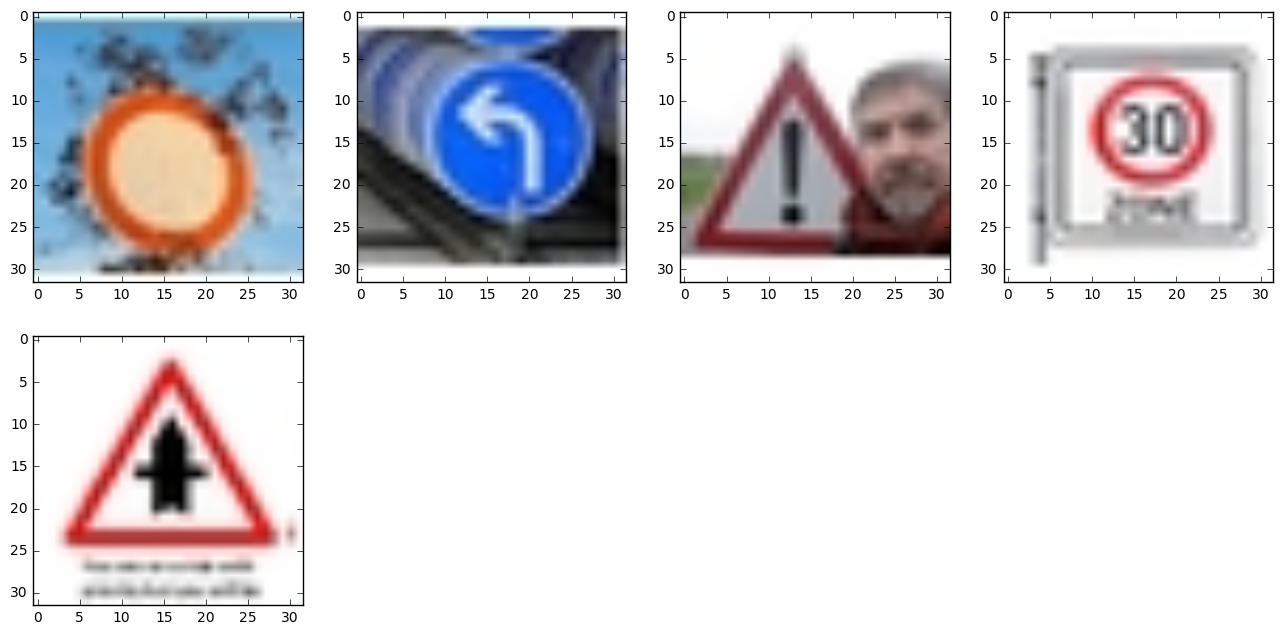

In [7]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline

images = []

plt.figure(figsize=[16, 16])
for i in range(1, 6):
    plt.subplot(4, 4, i)
    image = mpimg.imread('image/' + str(i) + '.png')
    images.append(image)
    plt.imshow(image)

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



**Answer:**

If the image is dark, it's hard to classify them.

In [8]:
### Run the predictions here.
### Feel free to use as many code cells as needed.
# sess = tf.get_default_session()
# images = np.array(images)

X = np.array(list(map(preprocess, images)))
prediction = tf.argmax(fc2, 1)
output = sess.run(prediction, feed_dict = {x: X, keep_prob: 1})

dict = {}
file = open('signnames.csv')
for line in file:
    item = line[:-1].split(',')
    dict[item[0]] = item[1]

for ans in output:
    print(ans, dict[str(ans)])

15 No vehicles
40 Roundabout mandatory
18 General caution
17 No entry
18 General caution


### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


**Answer:**

Only the first and the third prediction are correct.

In [9]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.

prediction_softmax = tf.nn.softmax(fc2)
result = sess.run(prediction_softmax, feed_dict = {x: X, keep_prob: 1})
print(result)

[[  1.02501266e-28   5.02740956e-14   1.58357137e-22   4.85070078e-25
    5.75664877e-21   4.70873772e-29   0.00000000e+00   1.02093556e-34
    5.78565280e-25   1.16132166e-23   1.81645116e-32   0.00000000e+00
    1.58070550e-21   1.56674510e-17   1.29682319e-16   1.00000000e+00
    0.00000000e+00   2.07285588e-23   4.45172846e-25   0.00000000e+00
    0.00000000e+00   8.68306820e-34   7.26619935e-17   0.00000000e+00
    9.35909868e-34   8.61970278e-19   6.64542889e-21   0.00000000e+00
    1.27517530e-38   7.79148847e-15   5.53485923e-32   5.80167021e-27
    2.39918144e-34   5.74486542e-37   0.00000000e+00   7.76064872e-35
    0.00000000e+00   0.00000000e+00   1.01548862e-29   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   1.32111483e-31   9.71979126e-26   6.90653434e-38
    0.00000000e+00   3.52044054e-31   2.60612098e-37   1.30410604e-23
    1.22172618e-28   0.00000000e+00   0.00000000e+00   7.84674438e-33
    1.00302988e-29   4.34595701e-37 

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

**Answer:**

See the second image, the correct result should be 34(Turn Left Ahead), The model was incorrect in its initial prediction, but the it's correct in top 2.

For fourth image, the correct prediction is at top 4.

For the fifth image, I don't it's name in English...Maybe it's not in the training set? It's really similar with General caution

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In [12]:
print(sess.run(tf.nn.top_k(prediction_softmax, 5), feed_dict={x: X, keep_prob: 1.0}))

TopKV2(values=array([[  1.00000000e+00,   5.02740956e-14,   7.79148847e-15,
          1.29682319e-16,   7.26619935e-17],
       [  5.24696231e-01,   4.75303710e-01,   3.63019055e-08,
          1.30410604e-23,   9.71979126e-26],
       [  9.95101810e-01,   3.21076042e-03,   1.06747786e-03,
          5.48866170e-04,   5.38838431e-05],
       [  9.98464108e-01,   1.16336788e-03,   2.10484897e-04,
          7.35352442e-05,   4.94404230e-05],
       [  1.00000000e+00,   1.34665182e-10,   8.62813806e-16,
          8.95668169e-19,   3.24265812e-19]], dtype=float32), indices=array([[15,  1, 29, 14, 22],
       [40, 34, 38,  7,  2],
       [18, 26, 25, 31, 27],
       [17, 26, 38,  1, 18],
       [18, 11, 31,  5,  7]], dtype=int32))
